In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm as LogNorm
from matplotlib import cm
import numpy as np
from scipy import stats
import pickle
import pandas as pd

# Event Selection Optimization

Branching off of lab 5, I'll be determining how precisely to make cuts on the dataset in order to produce the highest expected yield ratio of higgs events to background events, referred to as "significance". As decided previously, the first feature I'll apply limits to is mass. I'll plot other features post-cut to see if further event selection can be advantageous.

In the dataset for low momentum experiments, we are given that per 20,000 background events, we have an expected yield of 100 higgs events. In order to normalize the two, equal length datasets we are given, we must normalize using this ratio.

In [2]:
file1 = open ("qcd_100000_pt_250_500.pkl",'rb')
file2 = open ("higgs_100000_pt_250_500.pkl",'rb')

qcd = pickle.load(file1)
higgs = pickle.load(file2)

keys = qcd.keys()


The maximum mass value in our higgs dataset is 142.440, and min is 8.971.



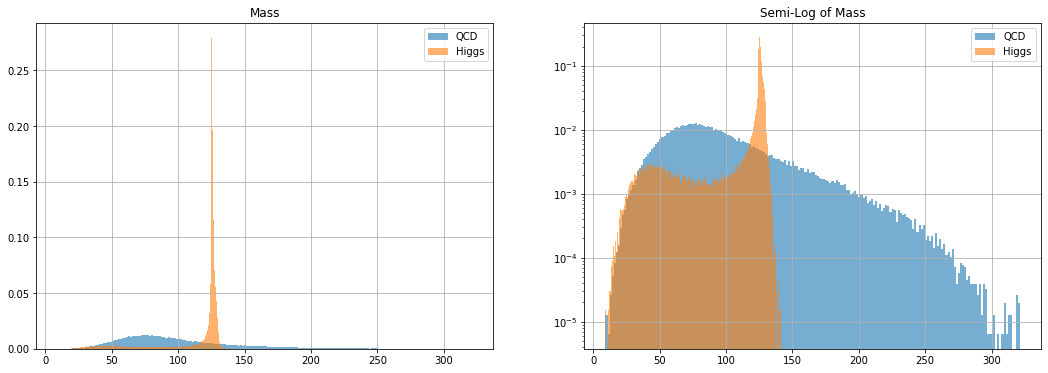

In [3]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,6)

ax[0].hist(qcd[keys[3]],bins=200,density=True,label='QCD',alpha=0.6)
ax[0].hist(higgs[keys[3]],bins=200,density=True,label='Higgs',alpha=0.6)
ax[0].set_title('Mass')

ax[1].hist(qcd[keys[3]],bins=200,density=True,label='QCD',alpha=0.6,log=True)
ax[1].hist(higgs[keys[3]],bins=200,density=True,label='Higgs',alpha=0.6,log=True)
ax[1].set_title('Semi-Log of Mass')

ax[0].grid()
ax[0].legend()
ax[1].grid()
ax[1].legend();

maxmass = np.max(higgs[keys[3]])
minmass = np.min(higgs[keys[3]])
print("\nThe maximum mass value in our higgs dataset is {0:.3f}, and min is {1:.3f}.\n".format(maxmass,minmass))

In [4]:
#given in dataset description...
Nhiggs_exp = 100.
Nqcd_exp = 20000.
norm = Nhiggs_exp / Nqcd_exp
u = Nhiggs_exp / np.sqrt(Nqcd_exp)

uncut_sens = (len(higgs)/len(qcd)) * norm
print("\nBefore making any cuts, the expected sensitivity is {0:.3f}; or, put another way, we expect to observe a Higgs event {1:%} of the time.\n".format(
uncut_sens,uncut_sens))
print("Our uncertainty on the number of detected higgs events as it stands is {0:.2f}.\n".format(u))


Before making any cuts, the expected sensitivity is 0.005; or, put another way, we expect to observe a Higgs event 0.500000% of the time.

Our uncertainty on the number of detected higgs events as it stands is 0.71.



In [5]:
def cut_the_feat(signal,background,labels,feat,low,high):
    Nhiggs_exp = 100.
    Nqcd_exp = 20000.
    norm = Nhiggs_exp / Nqcd_exp
    
    sens,uncertainty,prop = [],[],[]
    for i in range(len(low)):
        signal_keep = signal.copy()
        bkgd_keep = background.copy()
        
        signal_keep = signal_keep.loc[(signal_keep[labels[feat]] > low[i]) & (signal_keep[labels[feat]] < high[i])]
        bkgd_keep = bkgd_keep.loc[(bkgd_keep[labels[feat]] > low[i]) & (bkgd_keep[labels[feat]] < high[i])]
        
        sigN,bkgdN = len(signal_keep),len(bkgd_keep)
        
        r = sigN / bkgdN
        
        s = r * norm
        u = ((sigN/(sigN+bkgdN))*Nhiggs_exp) / np.sqrt((bkgdN/(sigN+bkgdN))*Nqcd_exp)
        
        sens.append(s)
        uncertainty.append(u)
        prop.append([i,s,u,sigN/len(signal),bkgdN/len(background)])
        
    return sens,uncertainty,prop

In [6]:
# an array of possible mass interval constrains from 0 to 110 counting by 10
masslow = np.linspace(0,110,12)
masshigh = np.full(len(masslow),143.)

m_s,m_unc,m_prop = cut_the_feat(signal=higgs,background=qcd,labels=keys,feat=3,low=masslow,high=masshigh)
m_prop

[[0, 0.0058443987282588376, 0.5612251166480255, 1.0, 0.85552],
 [1, 0.00584447691408533, 0.561230601492353, 0.99999, 0.8555],
 [2, 0.005842067706992958, 0.5610615774519694, 0.99883, 0.85486],
 [3, 0.005832094658361646, 0.5603615668462825, 0.98875, 0.84768],
 [4, 0.0058758178678276944, 0.563426620567434, 0.96629, 0.82226],
 [5, 0.006098766233766234, 0.5789014468745834, 0.93921, 0.77],
 [6, 0.00669615440853926, 0.6191614563564571, 0.9159, 0.6839],
 [7, 0.007836485566092104, 0.691668933415249, 0.89745, 0.57261],
 [8, 0.009779333451673028, 0.8044180942401123, 0.88147, 0.45068],
 [9, 0.012926800155172929, 0.9654719179273834, 0.86638, 0.33511],
 [10, 0.01788132025428367, 1.1821131312404842, 0.84947, 0.23753],
 [11, 0.025804139134771226, 1.4702284985797172, 0.8279, 0.16042]]

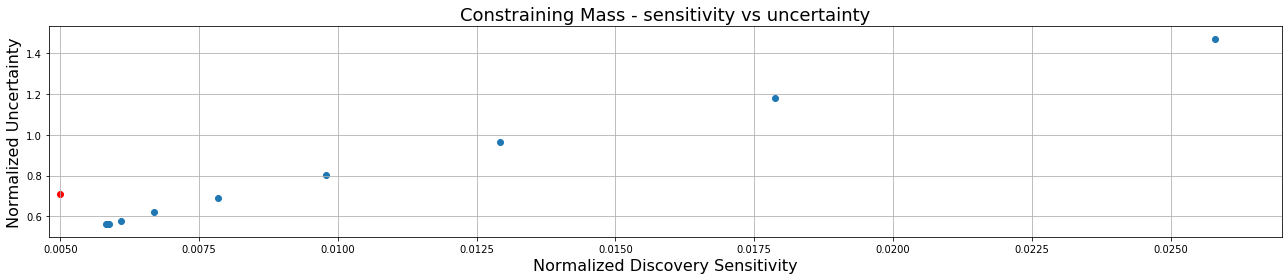

In [7]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,4)

ax.scatter(m_s,m_unc)
ax.scatter(uncut_sens,u,c='r')
ax.set_xlim(0.0048,0.027)
ax.set_xlabel('Normalized Discovery Sensitivity',fontsize=16)
ax.set_ylabel('Normalized Uncertainty',fontsize=16)

ax.set_title('Constraining Mass - sensitivity vs uncertainty',fontsize=18)
ax.grid()
fig.tight_layout()

The red dot signifies our uncut dataset's sensitivty & uncertainty. This drops as we make our cuts, but only for a very small increase in sensitivity. Our normalized uncertainty $N_{higgs} / \sqrt{N_{QCD}}$ soon increases with increasing cuts. Our values clumped up at the beginning, denoting no change in width for those mass constraints of 0, 10, 20, 30, and 40 to 143. This width increases as we cut more and more N from our data. Generally, this means our confidence in our data being Higgs events stretches across a larger probabilistic space, and becomes less able to be approximated by a normal distribution.

We can consult the table printed in the last cell and see that our last datapoint corresponds to retaining only 16% our background data and 82.8% of our higgs data. This is too large a cut, so I think our cut corresponding to a mass range of 90 to 143 GeV, a sensitivity of 0.0129 and an uncertainty of 0.965 (comprised of 86.6% of our original higgs data and 33.5% of our original background data) will give us roughly Gaussian widths for our confidence interval.

Now, a comparison of our original features with our newly uncut features:

In [8]:
#making the cuts
m_qcd = qcd.copy()
m_higgs = higgs.copy()

m_qcd = m_qcd.loc[(m_qcd[keys[3]] > 90.) & (m_qcd[keys[3]] < 143.)]
m_higgs = m_higgs.loc[(m_higgs[keys[3]] > 90.) & (m_higgs[keys[3]] < 143.)]

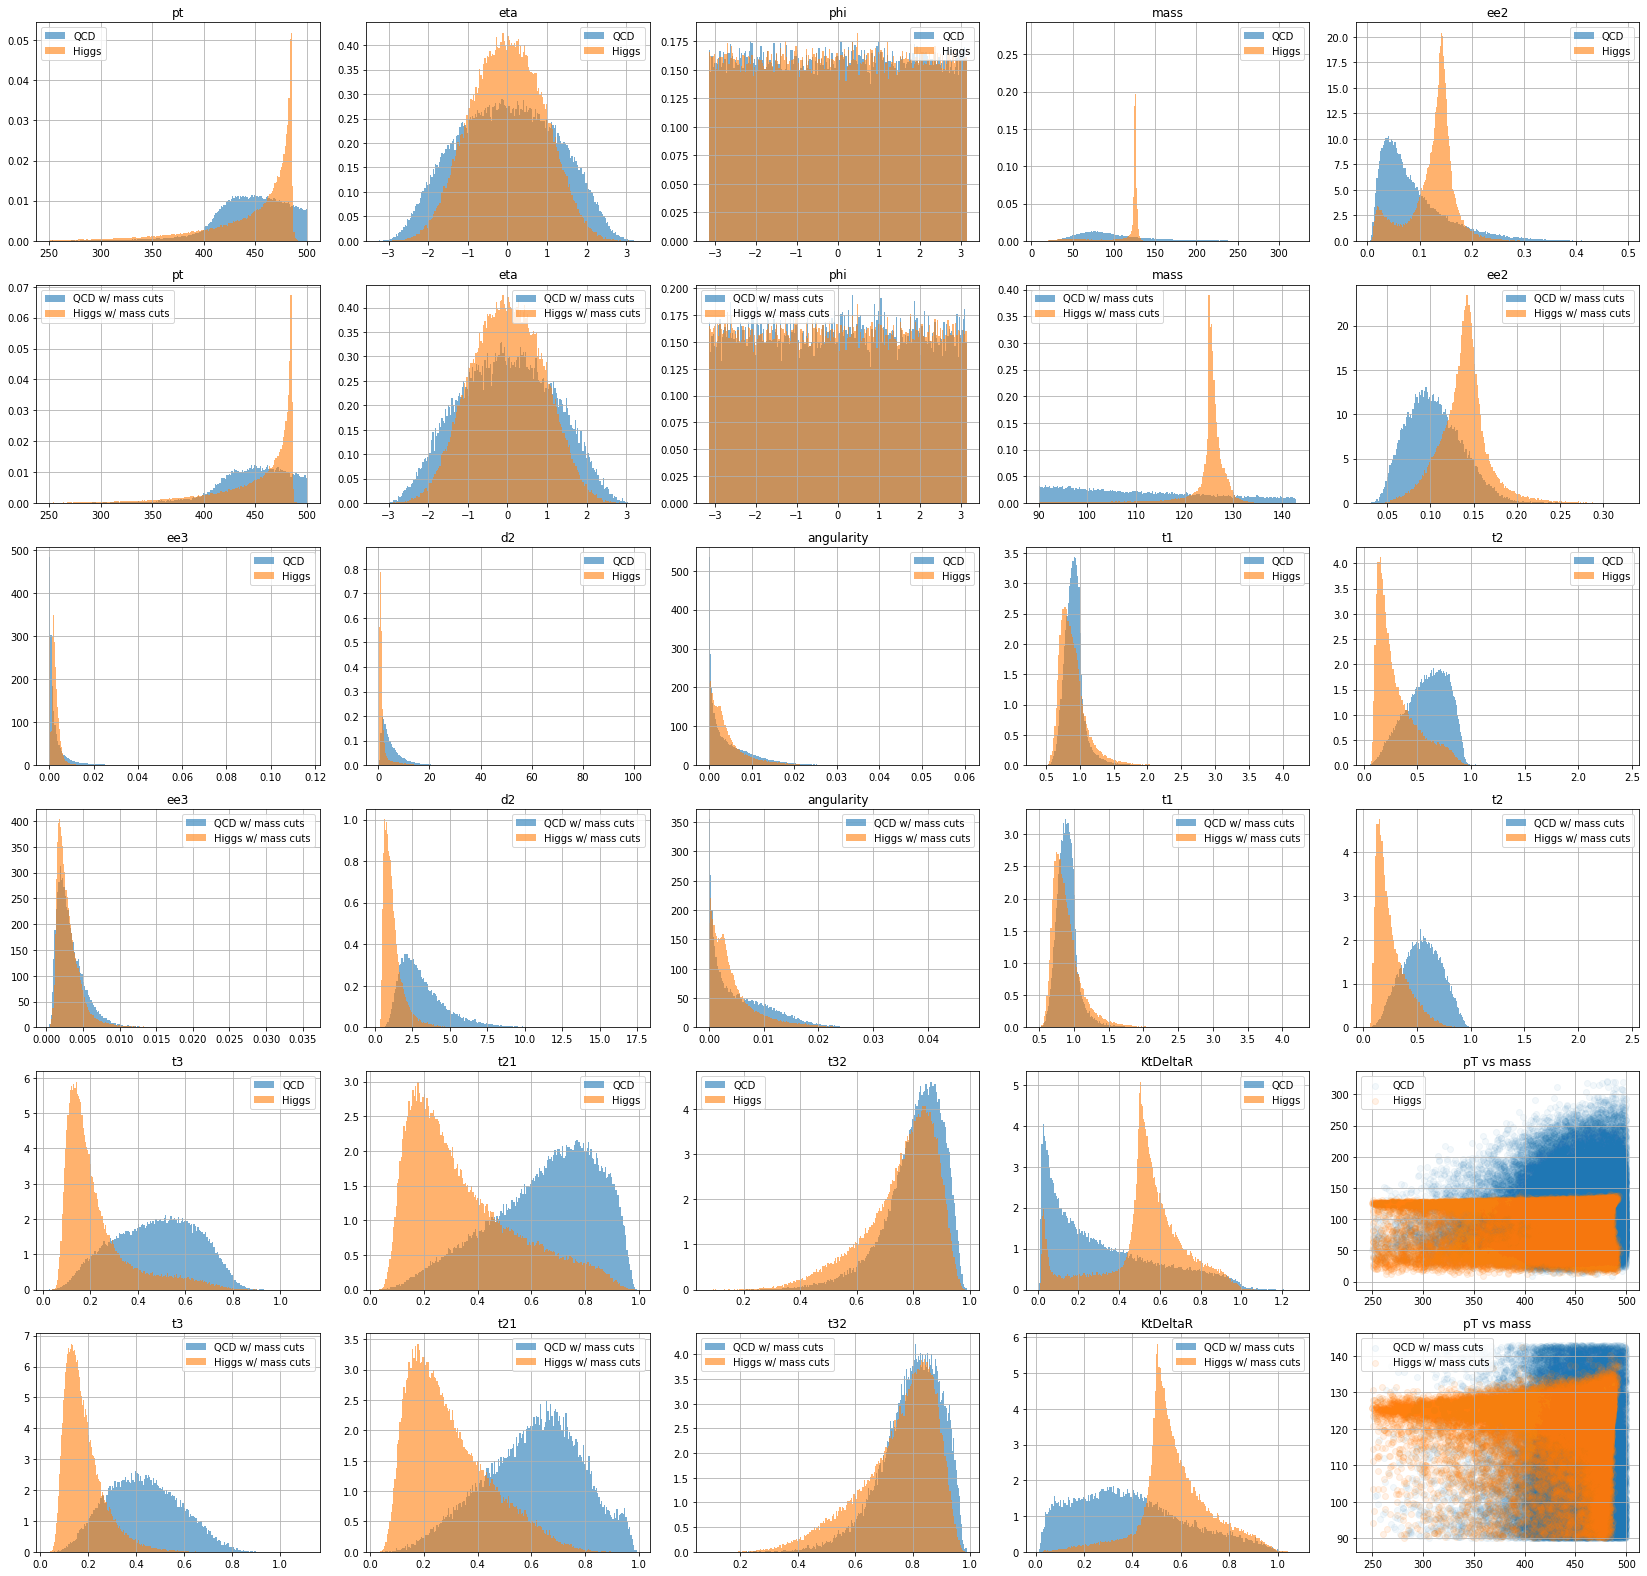

In [9]:
fig, ax = plt.subplots(6,5)
fig.set_size_inches(23,22)

for i in range(14):
    if i < 5:
        ax[0,i].hist(qcd[keys[i]],bins=200,density=True,label='QCD',alpha=0.6);
        ax[0,i].hist(higgs[keys[i]],bins=200,density=True,label='Higgs',alpha=0.6)
        ax[0,i].set_title(keys[i])
        ax[0,i].grid()
        ax[0,i].legend()
        
        ax[1,i].hist(m_qcd[keys[i]],bins=200,density=True,label='QCD w/ mass cuts',alpha=0.6);
        ax[1,i].hist(m_higgs[keys[i]],bins=200,density=True,label='Higgs w/ mass cuts',alpha=0.6)
        ax[1,i].set_title(keys[i])
        ax[1,i].grid()
        ax[1,i].legend()
    if 5 <= i < 10:
        ax[2,i-5].hist(qcd[keys[i]],bins=200,density=True,label='QCD',alpha=0.6);
        ax[2,i-5].hist(higgs[keys[i]],bins=200,density=True,label='Higgs',alpha=0.6)
        ax[2,i-5].set_title(keys[i])
        ax[2,i-5].grid()
        ax[2,i-5].legend()
        
        ax[3,i-5].hist(m_qcd[keys[i]],bins=200,density=True,label='QCD w/ mass cuts',alpha=0.6);
        ax[3,i-5].hist(m_higgs[keys[i]],bins=200,density=True,label='Higgs w/ mass cuts',alpha=0.6)
        ax[3,i-5].set_title(keys[i])
        ax[3,i-5].grid()
        ax[3,i-5].legend()
    if 10 <= i < 14:
        ax[4,i-10].hist(qcd[keys[i]],bins=200,density=True,label='QCD',alpha=0.6);
        ax[4,i-10].hist(higgs[keys[i]],bins=200,density=True,label='Higgs',alpha=0.6)
        ax[4,i-10].set_title(keys[i])
        ax[4,i-10].grid()
        ax[4,i-10].legend()
        
        ax[5,i-10].hist(m_qcd[keys[i]],bins=200,density=True,label='QCD w/ mass cuts',alpha=0.6);
        ax[5,i-10].hist(m_higgs[keys[i]],bins=200,density=True,label='Higgs w/ mass cuts',alpha=0.6)
        ax[5,i-10].set_title(keys[i])
        ax[5,i-10].grid()
        ax[5,i-10].legend()
        
        

ax[4,4].scatter(qcd[keys[0]],qcd[keys[3]],label='QCD',alpha=0.05)
ax[4,4].scatter(higgs[keys[0]],higgs[keys[3]],label='Higgs',alpha=0.1)
ax[4,4].set_title('pT vs mass')
ax[4,4].legend()
ax[4,4].grid()

ax[5,4].scatter(m_qcd[keys[0]],m_qcd[keys[3]],label='QCD w/ mass cuts',alpha=0.05)
ax[5,4].scatter(m_higgs[keys[0]],m_higgs[keys[3]],label='Higgs w/ mass cuts',alpha=0.1)
ax[5,4].set_title('pT vs mass')
ax[5,4].legend()
ax[5,4].grid()

fig.tight_layout()

Heh this makes my computer sound like a jet. Anyways. These histograms are not showing relative frequency, otherwise we would have seen our blue background regions dwarfed by our orange (done by setting density=True, normalizing the y-axis). So, all changes in shape are due to the restructuring of the dataset. Some of the features didn't change much - understandably, those are eta & phi (our energy-based coordinates), angularity (feature denoting symmetry). I was surprised to see that pt (momentum) barely changed.

Some small changes occured in the shape of our 2 and 3 point energy correlation functions, but not enough to make cuts on. However, d2, the way in which we can distinguish between two-prong jets (given by e3 / (e2 cubed)) does show potential opportunity to make a cut at around 2.5.

While their ratios did not change, t2 and t3's tails certainly changed. Since these features refer to the average distance from an individual particle to another in the same branch if grouped into 2 (t2) or 3 (t3) branches, we can take this to mean that the higgs events which had larger-than-average values for this distance also had lower-than-average masses, and were cut from the dataset. There may be an opportunity to make a cut on t3.

Finally, we settle on KtDeltaR, the angular separation of two subjets clustered by kT. The spike it had close to zero is gone, and we are left with a relatively unchanged spike around 0.5. Making a cut at 0.4 seems like it would trim away the most, since our QCD distribution is asymmetric and heavily weighted on that side.

So, let's look at some log plots of d2, t3, and KtDeltaR.

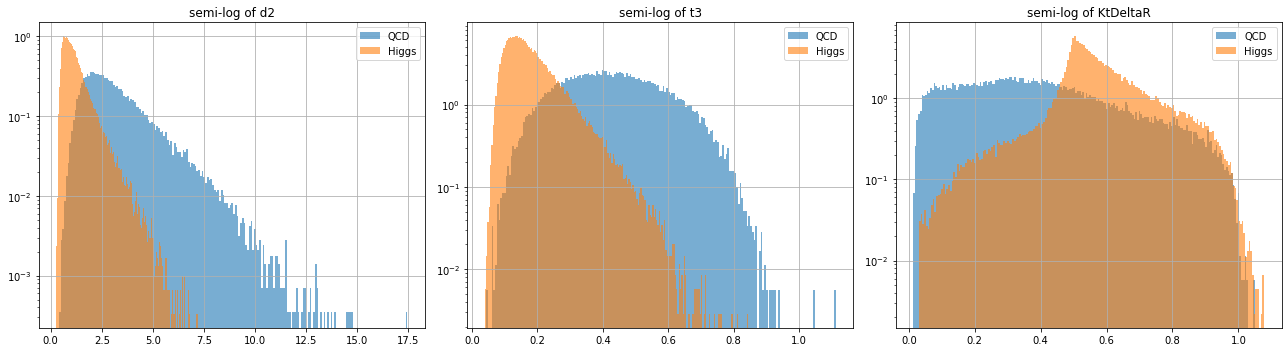

In [10]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(18,5)
        
ax[0].hist(m_qcd[keys[6]],bins=200,density=True,label='QCD',alpha=0.6,log=True)
ax[0].hist(m_higgs[keys[6]],bins=200,density=True,label='Higgs',alpha=0.6,log=True)
ax[0].set_title('semi-log of d2')

ax[1].hist(m_qcd[keys[10]],bins=200,density=True,label='QCD',alpha=0.6,log=True)
ax[1].hist(m_higgs[keys[10]],bins=200,density=True,label='Higgs',alpha=0.6,log=True)
ax[1].set_title('semi-log of t3')

ax[2].hist(m_qcd[keys[13]],bins=200,density=True,label='QCD',alpha=0.6,log=True)
ax[2].hist(m_higgs[keys[13]],bins=200,density=True,label='Higgs',alpha=0.6,log=True)
ax[2].set_title('semi-log of KtDeltaR')

for i in range(3):
    ax[i].grid()
    ax[i].legend()
    
fig.tight_layout()

d2 definitely has the cleanest separation from QCD. making a cut around 6 would exclude very few Higgs data points. We can check on the other two features once we make this cut.

In [11]:
# an array of possible d2 interval constrains, starting at a VERY safe upper limit of 7 and decreasing by 0.363636
d2high = np.linspace(7,3,12)
d2low = np.zeros(len(d2high))

d_s,d_unc,d_prop = cut_the_feat(signal=m_higgs,background=m_qcd,labels=keys,feat=6,low=d2low,high=d2high)
print(d_prop[-2])
print('\n')
print(d2high[-2])

[10, 0.0198512335027748, 1.2592545328484344, 0.9826404118285279, 0.6398794425710961]


3.3636363636363633


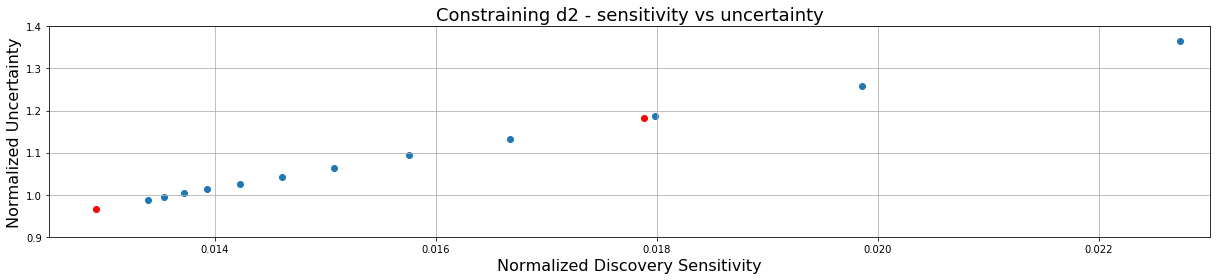

In [12]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(17,4)

ax.scatter(d_s,d_unc)
ax.scatter(m_s,m_unc,c='r')
ax.set_xlim(0.0125,0.023)
ax.set_ylim(0.9,1.4)
ax.set_xlabel('Normalized Discovery Sensitivity',fontsize=16)
ax.set_ylabel('Normalized Uncertainty',fontsize=16)

ax.set_title('Constraining d2 - sensitivity vs uncertainty',fontsize=18)
ax.grid()
fig.tight_layout()

Cool, that first red dot just under 1 uncertainty corresponds to our chosen mass cut, aka the dataset we used in calculating our d2 cut! The second red dot is another mass cut we could have gone with. Interestingly, it falls along the same line as our d2 cuts, telling me that the same increase in sensitivity would yield the same increase in uncertainty. This makes sense. The more we throw out, the wider our distribution becomes.

This now feels a bit like an exercise in futility, trying to keep our uncertainty low by taking cuts from different features. However, I am interested to see if our d2 cut will change the shape of our other features. I'll choose the second to last data point cuz I'm feelin crazy. This corresponds to a d2 interval of 0 to 3.3636, which bumps our sensitivity up to 0.0198 (from 0.0129), uncertainty up to 1.259, preserving 98.3% of our mass cut higgs, and preserving 64% of our mass cut qcd background.

In [13]:
#making the cuts
d_qcd = m_qcd.copy()
d_higgs = m_higgs.copy()

d_qcd = d_qcd.loc[(d_qcd[keys[6]] > 0.) & (d_qcd[keys[6]] < 3.363636)]
d_higgs = d_higgs.loc[(d_higgs[keys[6]] > 0.) & (d_higgs[keys[6]] < 3.363636)]

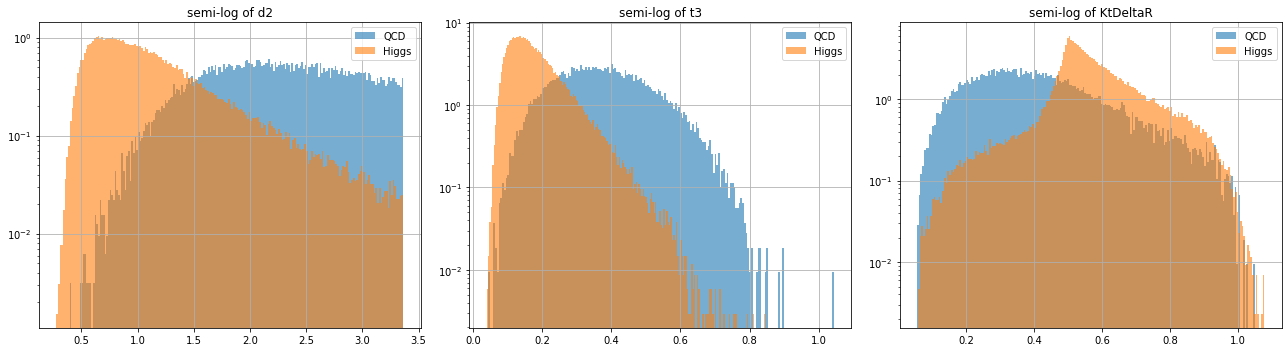

In [14]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(18,5)
        
ax[0].hist(d_qcd[keys[6]],bins=200,density=True,label='QCD',alpha=0.6,log=True)
ax[0].hist(d_higgs[keys[6]],bins=200,density=True,label='Higgs',alpha=0.6,log=True)
ax[0].set_title('semi-log of d2')

ax[1].hist(d_qcd[keys[10]],bins=200,density=True,label='QCD',alpha=0.6,log=True)
ax[1].hist(d_higgs[keys[10]],bins=200,density=True,label='Higgs',alpha=0.6,log=True)
ax[1].set_title('semi-log of t3')

ax[2].hist(d_qcd[keys[13]],bins=200,density=True,label='QCD',alpha=0.6,log=True)
ax[2].hist(d_higgs[keys[13]],bins=200,density=True,label='Higgs',alpha=0.6,log=True)
ax[2].set_title('semi-log of KtDeltaR')

for i in range(3):
    ax[i].grid()
    ax[i].legend()
    
fig.tight_layout()

These really didn't change much, but just for good measure, let's make a cut according to t3. Then after this, we'll plot the correlations of those three features - mass, d2, and t3. 

In [15]:
# t3 interval constrains, starting at a safe upper limit of 0.6, decreasing by 0.02
t3high = np.linspace(0.6,0.38,12)
t3low = np.zeros(len(t3high))

t_s,t_unc,t_prop = cut_the_feat(signal=d_higgs,background=d_qcd,labels=keys,feat=10,low=t3low,high=t3high)
t_prop[-1]

[11,
 0.036970753957606656,
 1.8046164918451126,
 0.9711043766297837,
 0.5214289045376114]

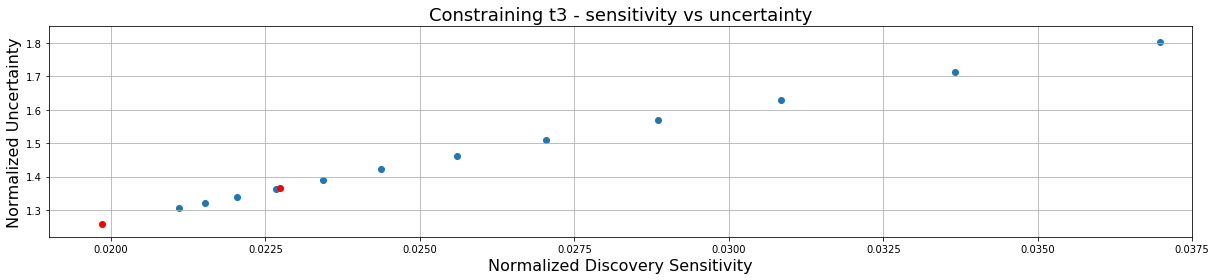

In [16]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(17,4)

ax.scatter(t_s,t_unc)
ax.scatter(d_s,d_unc,c='r')
ax.set_xlim(0.019,0.0375)
ax.set_ylim(1.22,1.85)
ax.set_xlabel('Normalized Discovery Sensitivity',fontsize=16)
ax.set_ylabel('Normalized Uncertainty',fontsize=16)

ax.set_title('Constraining t3 - sensitivity vs uncertainty',fontsize=18)
ax.grid()
fig.tight_layout()

Even though we were changing our constraint by a constant amount, we can see here that our blue dots begin to get more and more spaced out. This has always been the case, but now it makes me think there might be some sort of maximum sensitivity... So I'm going to do the same thing again to the dataset cut by d2, except tighten the constrain a dumb amount.

In [17]:
# an array of possible t3 interval constrains, starting at an unsafe upper limit of 0.34, decreasing by 0.02
tight3high = np.linspace(0.34,0.1,12)
tight3low = np.zeros(len(tight3high))

tight_s,tight_unc,tight_prop = cut_the_feat(signal=d_higgs,background=d_qcd,labels=keys,feat=10,low=tight3low,high=tight3high)
tight_prop[-1]

[11,
 0.7019672131147542,
 8.348668010129487,
 0.10059435713111095,
 0.002844751200858089]

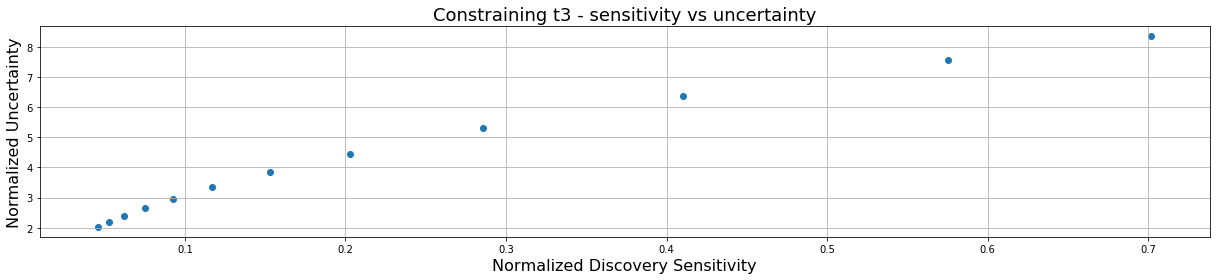

In [18]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(17,4)

ax.scatter(tight_s,tight_unc)
ax.set_xlabel('Normalized Discovery Sensitivity',fontsize=16)
ax.set_ylabel('Normalized Uncertainty',fontsize=16)

ax.set_title('Constraining t3 - sensitivity vs uncertainty',fontsize=18)
ax.grid()
fig.tight_layout()

Whoa. That's a super high discovery sensitivity of 0.7 and uncertainty of 8.3. We've also thrown out 90% of our dataset.

Now I'm curious about what it looks like when we do this cut on our original dataset...

In [19]:
tightmasslow = np.linspace(30,130,12)
tightmasshigh = np.full(len(tightmasslow),143.)

tightd2high = np.linspace(4,0.5,12)
tightd2low = np.zeros(len(tightd2high))

monly_s,monly_unc,monly_prop = cut_the_feat(signal=higgs,background=qcd,labels=keys,feat=3,low=tightmasslow,high=tightmasshigh)
donly_s,donly_unc,donly_prop = cut_the_feat(signal=higgs,background=qcd,labels=keys,feat=6,low=tightd2low,high=tightd2high)
tonly_s,tonly_unc,tonly_prop = cut_the_feat(signal=higgs,background=qcd,labels=keys,feat=10,low=tight3low,high=tight3high)

print(monly_prop[-1])
print(donly_prop[-1])
print(tonly_prop[-1])

[11, 0.0022842430484037073, 0.26763943094902776, 0.02218, 0.04855]
[11, 0.16865591397849464, 4.047219747268387, 0.03137, 0.00093]
[11, 0.10395631067961165, 3.149377088341543, 0.08566, 0.00412]


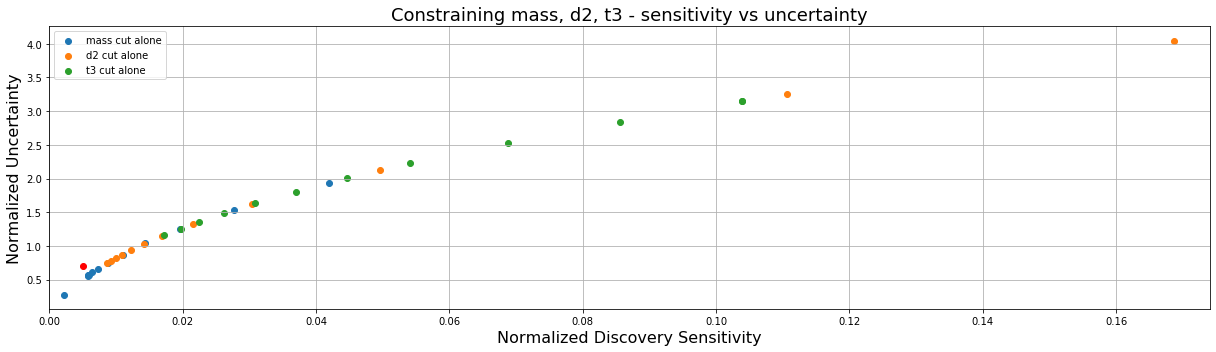

In [20]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(17,5)

ax.scatter(monly_s,monly_unc,label='mass cut alone')
ax.scatter(donly_s,donly_unc,label='d2 cut alone')
ax.scatter(tonly_s,tonly_unc,label='t3 cut alone')

ax.scatter(uncut_sens,u,c='r')

ax.set_xlim(0,0.174)
ax.set_xlabel('Normalized Discovery Sensitivity',fontsize=16)
ax.set_ylabel('Normalized Uncertainty',fontsize=16)
ax.set_title('Constraining mass, d2, t3 - sensitivity vs uncertainty',fontsize=18)
ax.grid()
ax.legend()
fig.tight_layout()

Right okay, so, these all fall on the same line of $N_{higgs} / \sqrt{N_{QCD}}$. The highest points shown are from d2 cuts, wtih a chance of measuring a higgs event of 16.7%, but with only 3.137% of our original higgs dataset and 0.1% of our original qcd background. This would give us rough 3 events to observe out of 200 qcd events. 

I should have started with this plot, but lucky you, you get my full unbriddled thought process.

Anyways, that last point in the regular t3 test I made earlier looked good, keeping 97.1% of our twice-cut higgs data and just 52.1% of our twice-cut qcd data, and scoring a sensitivity of 0.03697. Since this is our final cut, I'll calculate the final significance.

In [21]:
#making the cuts
t_qcd = d_qcd.copy()
t_higgs = d_higgs.copy()

t_qcd = t_qcd.loc[(t_qcd[keys[10]] > 0.) & (t_qcd[keys[10]] < t3high[-1])]
t_higgs = t_higgs.loc[(t_higgs[keys[10]] > 0.) & (t_higgs[keys[10]] < t3high[-1])]

In [22]:
Ncutqcd = len(t_qcd)
Ncuthiggs = len(t_higgs)

Ncutqcd_exp = Nqcd_exp * (Ncutqcd/(Ncutqcd+Ncuthiggs))
Ncuthiggs_exp = Nhiggs_exp * (Ncuthiggs/(Ncutqcd+Ncuthiggs))

final_sens = Ncuthiggs_exp / Ncutqcd_exp

print("\nAfter making the described cuts, we expect to observe {0:g} higgs events and {1:g} background events for a sensitivity of {2:%}.\n".format(
int(np.floor(Ncuthiggs_exp)),int(np.floor(Ncutqcd_exp)),final_sens))

diff = final_sens - uncut_sens
Nqcd_diff = Nqcd_exp - int(np.floor(Ncutqcd_exp))
Nhiggs_diff = Nhiggs_exp - int(np.floor(Ncuthiggs_exp))

print("This is up {0:%} from our uncut data! We threw out {1:g} or {2:%} of background datapoints while only throwing out {3:g} higgs events!\n".format(
diff,Nqcd_diff,Nqcd_diff/Nqcd_exp,Nhiggs_diff))

print("In total, we expect that we will only be retaining {0:%} of our data.\n".format(((Ncuthiggs_exp+Ncutqcd_exp)/(Nqcd_exp+Nhiggs_exp))))


After making the described cuts, we expect to observe 88 higgs events and 2382 background events for a sensitivity of 3.697075%.

This is up 3.197075% from our uncut data! We threw out 17618 or 88.090000% of background datapoints while only throwing out 12 higgs events!

In total, we expect that we will only be retaining 12.292032% of our data.



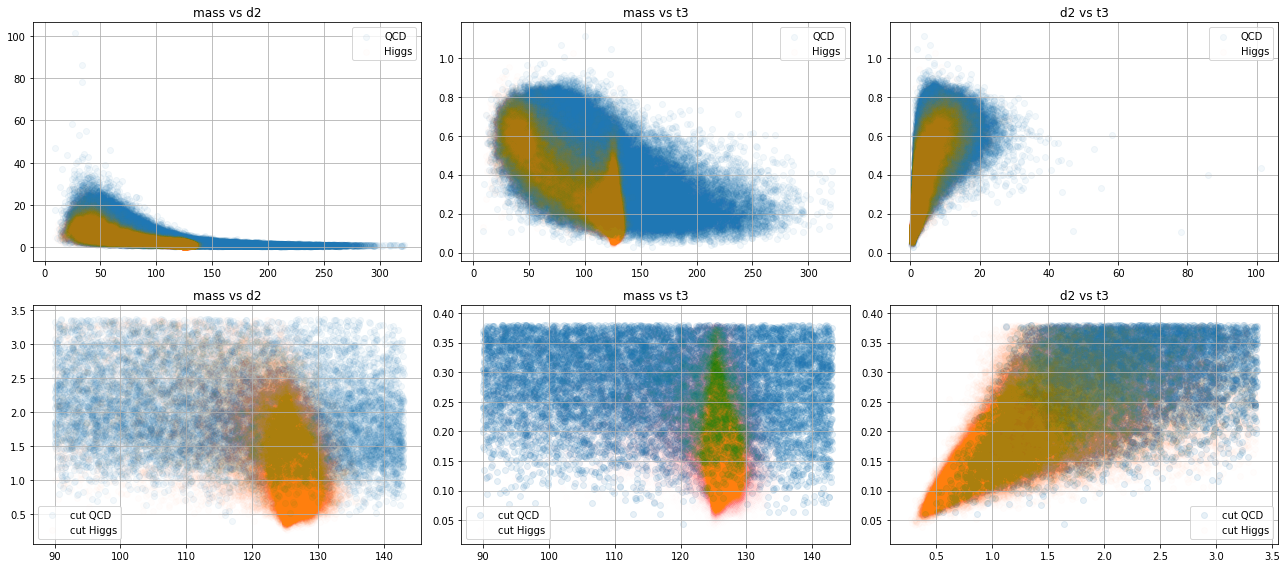

In [23]:
# EC

fig, ax = plt.subplots(2,3)
fig.set_size_inches(18,8)
        
ax[0,0].scatter(qcd[keys[3]],qcd[keys[6]],label='QCD',alpha=0.05)
ax[0,0].scatter(higgs[keys[3]],higgs[keys[6]],label='Higgs',alpha=0.01)
ax[0,0].set_title('mass vs d2')

ax[0,1].scatter(qcd[keys[3]],qcd[keys[10]],label='QCD',alpha=0.05)
ax[0,1].scatter(higgs[keys[3]],higgs[keys[10]],label='Higgs',alpha=0.01)
ax[0,1].set_title('mass vs t3')

ax[0,2].scatter(qcd[keys[6]],qcd[keys[10]],label='QCD',alpha=0.05)
ax[0,2].scatter(higgs[keys[6]],higgs[keys[10]],label='Higgs',alpha=0.01)
ax[0,2].set_title('d2 vs t3')

ax[1,0].scatter(t_qcd[keys[3]],t_qcd[keys[6]],label='cut QCD',alpha=0.05)
ax[1,0].scatter(t_higgs[keys[3]],t_higgs[keys[6]],label='cut Higgs',alpha=0.01)
ax[1,0].set_title('mass vs d2')

ax[1,1].scatter(t_qcd[keys[3]],t_qcd[keys[10]],label='cut QCD',alpha=0.1)
ax[1,1].scatter(t_higgs[keys[3]],t_higgs[keys[10]],label='cut Higgs',alpha=0.002)
ax[1,1].set_title('mass vs t3')

ax[1,2].scatter(t_qcd[keys[6]],t_qcd[keys[10]],label='cut QCD',alpha=0.1)
ax[1,2].scatter(t_higgs[keys[6]],t_higgs[keys[10]],label='cut Higgs',alpha=0.01)
ax[1,2].set_title('d2 vs t3')

for i in range(3):
    ax[0,i].grid()
    ax[0,i].legend()
    ax[1,i].grid()
    ax[1,i].legend()

fig.tight_layout()

This is actually quite uninteresting. We pretty much knew already that our mass is constrained pretty tightly in that area. It doesn't change with those features. Our last plot, d2 vs t3, does show correlation, but it's the same correlation our background data has. Boringgg. Next.

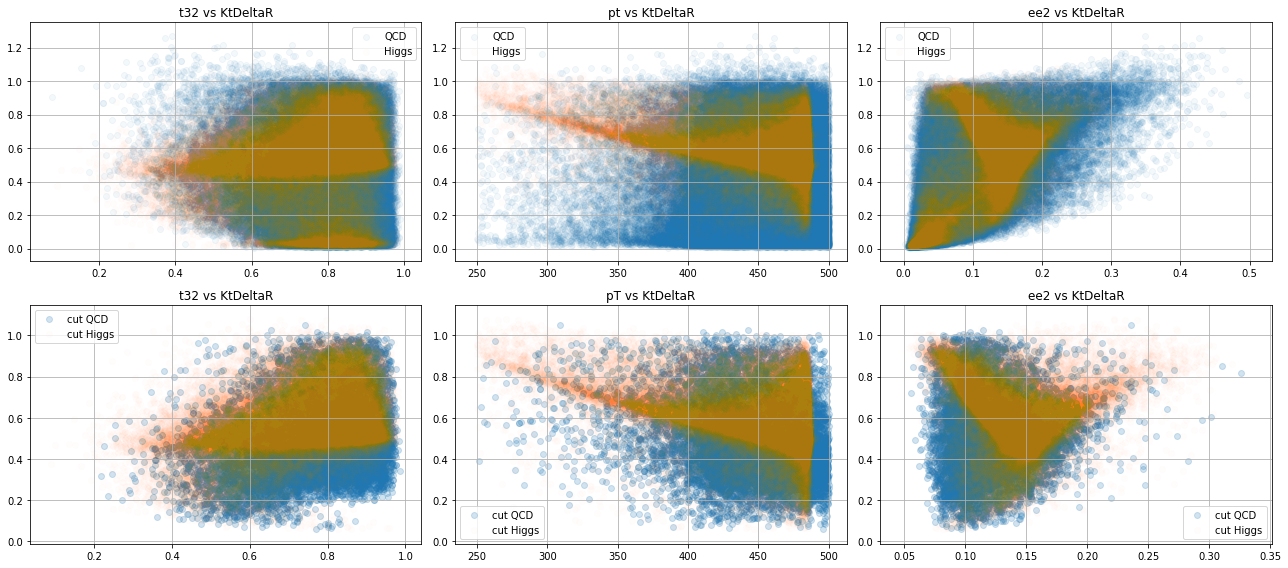

In [24]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(18,8)
        
ax[0,0].scatter(qcd[keys[12]],qcd[keys[13]],label='QCD',alpha=0.05)
ax[0,0].scatter(higgs[keys[12]],higgs[keys[13]],label='Higgs',alpha=0.01)
ax[0,0].set_title('t32 vs KtDeltaR')

ax[0,1].scatter(qcd[keys[0]],qcd[keys[13]],label='QCD',alpha=0.05)
ax[0,1].scatter(t_higgs[keys[0]],t_higgs[keys[13]],label='Higgs',alpha=0.01)
ax[0,1].set_title('pt vs KtDeltaR')

ax[0,2].scatter(qcd[keys[4]],qcd[keys[13]],label='QCD',alpha=0.05)
ax[0,2].scatter(higgs[keys[4]],higgs[keys[13]],label='Higgs',alpha=0.01)
ax[0,2].set_title('ee2 vs KtDeltaR')

ax[1,0].scatter(t_qcd[keys[12]],t_qcd[keys[13]],label='cut QCD',alpha=0.2)
ax[1,0].scatter(t_higgs[keys[12]],t_higgs[keys[13]],label='cut Higgs',alpha=0.01)
ax[1,0].set_title('t32 vs KtDeltaR')

ax[1,1].scatter(t_qcd[keys[0]],t_qcd[keys[13]],label='cut QCD',alpha=0.2)
ax[1,1].scatter(t_higgs[keys[0]],t_higgs[keys[13]],label='cut Higgs',alpha=0.01)
ax[1,1].set_title('pT vs KtDeltaR')

ax[1,2].scatter(t_qcd[keys[4]],t_qcd[keys[13]],label='cut QCD',alpha=0.2)
ax[1,2].scatter(t_higgs[keys[4]],t_higgs[keys[13]],label='cut Higgs',alpha=0.01)
ax[1,2].set_title('ee2 vs KtDeltaR')

for i in range(3):
    ax[0,i].grid()
    ax[0,i].legend()
    ax[1,i].grid()
    ax[1,i].legend()

fig.tight_layout()

These aren't excellent, but I've always been curious about KtDeltaR's shape in reference to other features. It seems like we can definitely make constraints based upon the fact that it has specific correlations with momentum and ee2... not so much with t32 but I did think it was intereting that it seems like the bottom half of the higgs dataset is cut off. It seems to me like we will always have a KtDeltaR larger than 0.4 when we've made our cuts, but there are also cuts that can be made for points of relatively low pT that aren't higher than 0.6 KtDeltaR. Additionally, we can shave off any KtDeltaR values larger than 0.75 that have a ee2 of 0.15 or more.

# Pseudo-Experiment Data Analysis

Now, we can make the feature cuts described above on the following datasets, which are grouped into high and low luminosity.

In [25]:
low = pd.read_hdf('data_lowLumi_pt_250_500.h5')
high = pd.read_hdf('data_highLumi_pt_250_500.h5')

In [63]:
# I'm combining in a very rough way (losing higgs data) for visualization purposes. length of qcd should be 20,000*5=100,000 and higgs 50*5=250
comb = qcd.append(higgs[::400])

# later, for combined cut, length of qcd should be 2382*4.7 = 11181 (no lost data) and length of higgs should be 88*4.7 = 414
t_comb = t_qcd.append(t_higgs[::200])

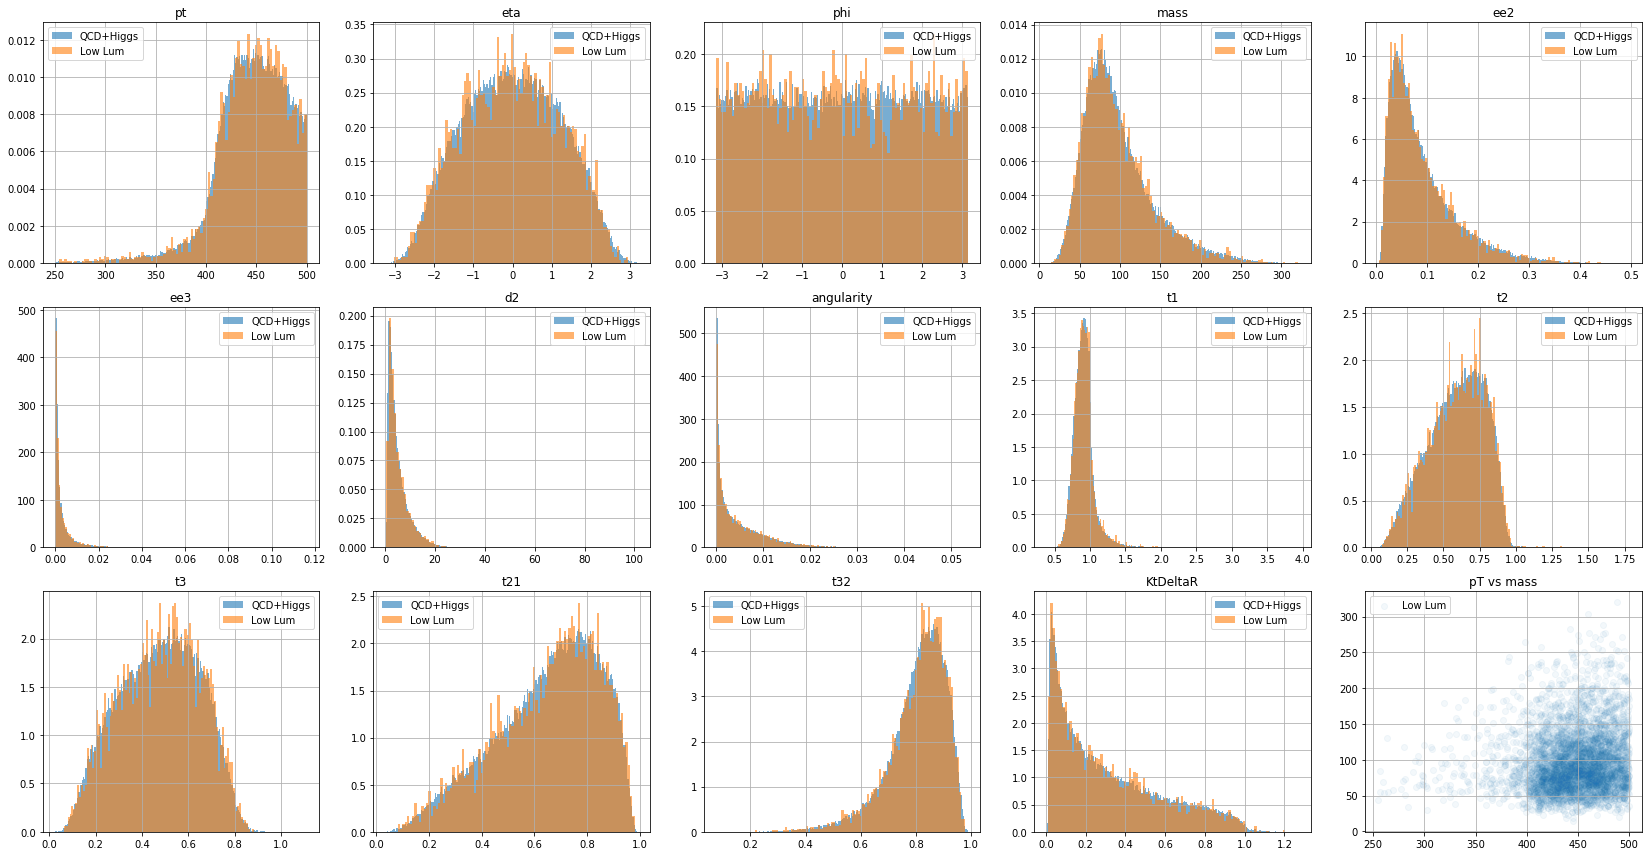

In [53]:
fig, ax = plt.subplots(3,5)
fig.set_size_inches(23,12)

for i in range(14):
    if i < 5:
        ax[0,i].hist(comb[keys[i]],bins=200,density=True,label='Normalized QCD+Higgs',alpha=0.6);
        #ax[0,i].hist(higgs[keys[i]],bins=200,density=True,label='Higgs',alpha=0.6)
        ax[0,i].hist(low[keys[i]],bins=100,density=True,label='Low Lum',alpha=0.6);
        ax[0,i].set_title(keys[i])
        ax[0,i].grid()
        ax[0,i].legend()
    if 5 <= i < 10:
        ax[1,i-5].hist(comb[keys[i]],bins=200,density=True,label='Normalized QCD+Higgs',alpha=0.6);
        #ax[1,i-5].hist(higgs[keys[i]],bins=200,density=True,label='Higgs',alpha=0.6)
        ax[1,i-5].hist(low[keys[i]],bins=100,density=True,label='Low Lum',alpha=0.6);
        ax[1,i-5].set_title(keys[i])
        ax[1,i-5].grid()
        ax[1,i-5].legend()
    if 10 <= i < 14:
        ax[2,i-10].hist(comb[keys[i]],bins=200,density=True,label='Normalized QCD+Higgs',alpha=0.6);
        #ax[2,i-10].hist(higgs[keys[i]],bins=200,density=True,label='Higgs',alpha=0.6)
        ax[2,i-10].hist(low[keys[i]],bins=100,density=True,label='Low Lum',alpha=0.6);
        ax[2,i-10].set_title(keys[i])
        ax[2,i-10].grid()
        ax[2,i-10].legend()

ax[2,4].scatter(low[keys[0]],low[keys[3]],label='Low Lum',alpha=0.05)
ax[2,4].set_title('pT vs mass')
ax[2,4].legend()
ax[2,4].grid()

fig.tight_layout()

Now let's look at our features: mass, d2, and t3.

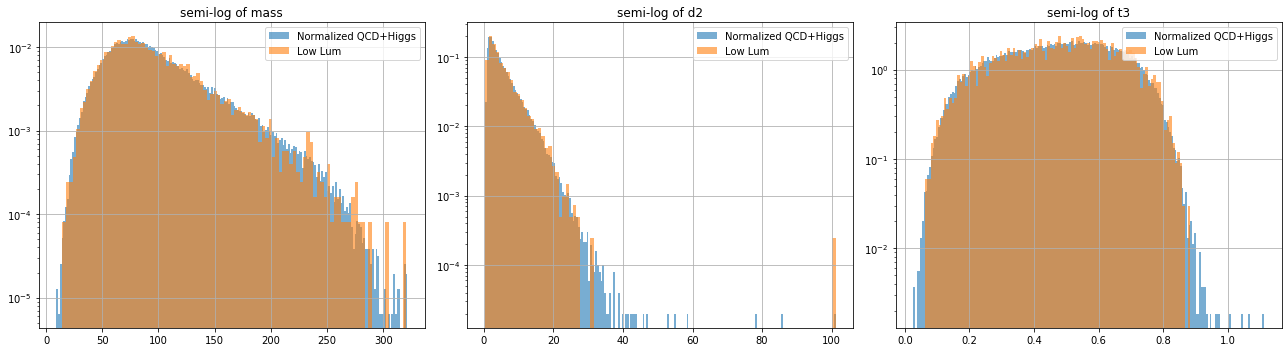

In [61]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(18,5)

ax[0].hist(comb[keys[3]],bins=200,density=True,label='Normalized QCD+Higgs',alpha=0.6,log=True)
ax[0].hist(low[keys[3]],bins=100,density=True,label='Low Lum',alpha=0.6,log=True)
ax[0].set_title('semi-log of mass')
        
ax[1].hist(comb[keys[6]],bins=200,density=True,label='Normalized QCD+Higgs',alpha=0.6,log=True)
ax[1].hist(low[keys[6]],bins=100,density=True,label='Low Lum',alpha=0.6,log=True)
ax[1].set_title('semi-log of d2')

ax[2].hist(comb[keys[10]],bins=200,density=True,label='Normalized QCD+Higgs',alpha=0.6,log=True)
ax[2].hist(low[keys[10]],bins=100,density=True,label='Low Lum',alpha=0.6,log=True)
ax[2].set_title('semi-log of t3')

for i in range(3):
    ax[i].grid()
    ax[i].legend()
    
fig.tight_layout()

Looks like our low lum has slightly diminished tails comparatively, which is a good sign. Time to make cuts!

In [57]:
Nlow_exp = len(low) * final_sens
Nhigh_exp = len(high) * final_sens

In [58]:
m_low = low.copy()
m_high = high.copy()

m_low = m_low.loc[(m_low[keys[3]] > 90.) & (m_low[keys[3]] < 143.)]
m_high = m_high.loc[(m_high[keys[3]] > 90.) & (m_high[keys[3]] < 143.)]

In [59]:
d_low = m_low.copy()
d_high = m_high.copy()

d_low = d_low.loc[(d_low[keys[6]] > 0.) & (d_low[keys[6]] < 3.363636)]
d_high = d_high.loc[(d_high[keys[6]] > 0.) & (d_high[keys[6]] < 3.363636)]

In [60]:
t_low = d_low.copy()
t_high = d_high.copy()

t_low = t_low.loc[(t_low[keys[10]] > 0.) & (t_low[keys[10]] < t3high[-1])]
t_high = t_high.loc[(t_high[keys[10]] > 0.) & (t_high[keys[10]] < t3high[-1])]

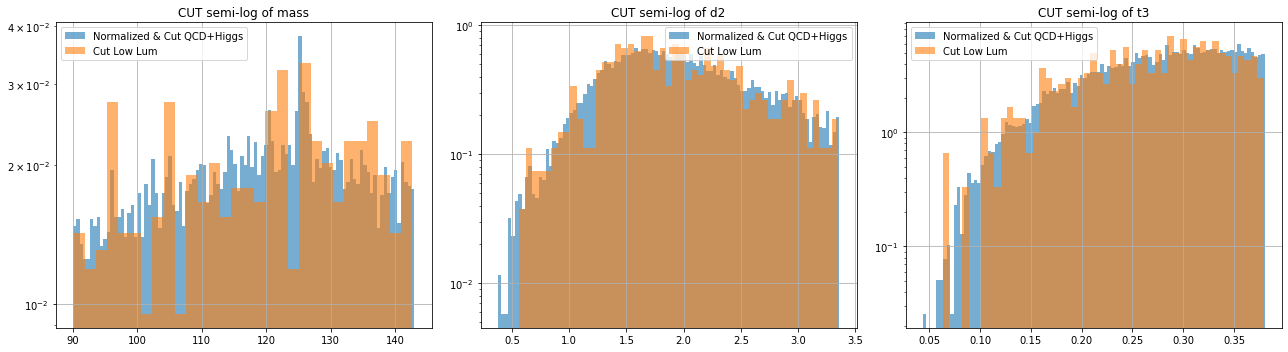

In [67]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(18,5)

ax[0].hist(t_comb[keys[3]],bins=100,density=True,label='Normalized & Cut QCD+Higgs',alpha=0.6,log=True)
ax[0].hist(t_low[keys[3]],bins=30,density=True,label='Cut Low Lum',alpha=0.6,log=True)
ax[0].set_title('CUT semi-log of mass')
        
ax[1].hist(t_comb[keys[6]],bins=100,density=True,label='Normalized & Cut QCD+Higgs',alpha=0.6,log=True)
ax[1].hist(t_low[keys[6]],bins=50,density=True,label='Cut Low Lum',alpha=0.6,log=True)
ax[1].set_title('CUT semi-log of d2')

ax[2].hist(t_comb[keys[10]],bins=100,density=True,label='Normalized & Cut QCD+Higgs',alpha=0.6,log=True)
ax[2].hist(t_low[keys[10]],bins=50,density=True,label='Cut Low Lum',alpha=0.6,log=True)
ax[2].set_title('CUT semi-log of t3')

for i in range(3):
    ax[i].grid()
    ax[i].legend()
    
fig.tight_layout()

Interesting. There are quite a few more holes in our mass estimate which is interesting. The tail also seems diminished for t3.

In [68]:
low_prop = len(t_low)/len(low)
Nlow = final_sens * len(t_low)

print("\nThe amount of data retained from the low luminosity dataset was {0:%} of the total. Expected number of higgs events is {1:g} (total={2:g}).\n".format(
    low_prop,Nlow,len(t_low)))


The amount of data retained from the low luminosity dataset was 11.798030% of the total. Expected number of higgs events is 17.709 (total=479).



Now for high luminosity!

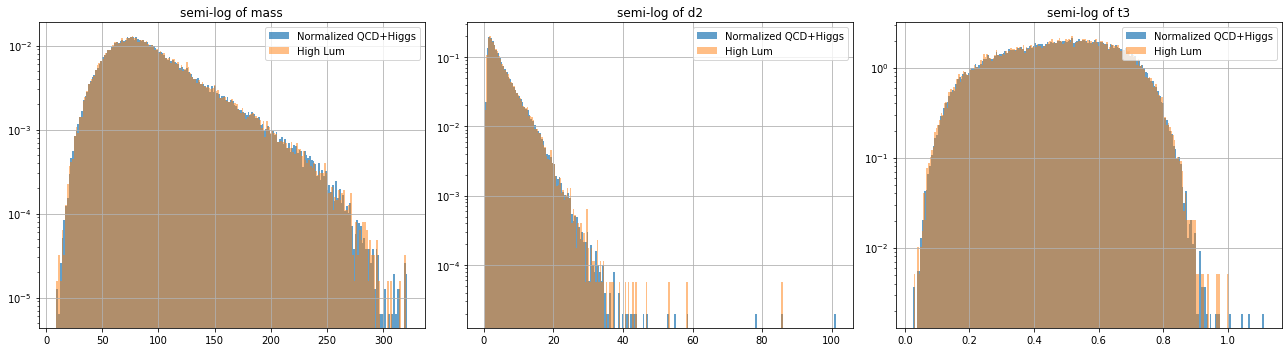

In [79]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(18,5)

ax[0].hist(comb[keys[3]],bins=200,density=True,label='Normalized QCD+Higgs',alpha=0.7,log=True)
ax[0].hist(high[keys[3]],bins=200,density=True,label='High Lum',alpha=0.5,log=True)
ax[0].set_title('semi-log of mass')
        
ax[1].hist(comb[keys[6]],bins=200,density=True,label='Normalized QCD+Higgs',alpha=.7,log=True)
ax[1].hist(high[keys[6]],bins=200,density=True,label='High Lum',alpha=.5,log=True)
ax[1].set_title('semi-log of d2')

ax[2].hist(comb[keys[10]],bins=200,density=True,label='Normalized QCD+Higgs',alpha=0.7,log=True)
ax[2].hist(high[keys[10]],bins=200,density=True,label='High Lum',alpha=0.5,log=True)
ax[2].set_title('semi-log of t3')

for i in range(3):
    ax[i].grid()
    ax[i].legend()
    
fig.tight_layout()

Whoa. High Luminosity data looks nearly identical to our training data. Let's test it and see how they look post-cut.

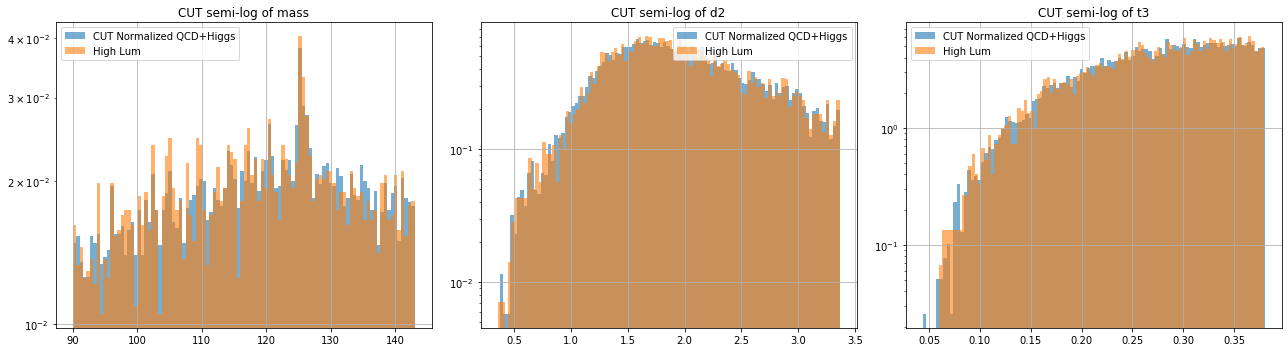

In [81]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(18,5)

ax[0].hist(t_comb[keys[3]],bins=100,density=True,label='CUT Normalized QCD+Higgs',alpha=0.6,log=True)
ax[0].hist(t_high[keys[3]],bins=100,density=True,label='High Lum',alpha=0.6,log=True)
ax[0].set_title('CUT semi-log of mass')
        
ax[1].hist(t_comb[keys[6]],bins=100,density=True,label='CUT Normalized QCD+Higgs',alpha=0.6,log=True)
ax[1].hist(t_high[keys[6]],bins=100,density=True,label='High Lum',alpha=0.6,log=True)
ax[1].set_title('CUT semi-log of d2')

ax[2].hist(t_comb[keys[10]],bins=100,density=True,label='CUT Normalized QCD+Higgs',alpha=0.6,log=True)
ax[2].hist(t_high[keys[10]],bins=100,density=True,label='High Lum',alpha=0.6,log=True)
ax[2].set_title('CUT semi-log of t3')

for i in range(3):
    ax[i].grid()
    ax[i].legend()
    
fig.tight_layout()

Again, nearly the same! We even have that cut mass spike going on.

In [82]:
high_prop = len(t_high)/len(high)
Nhigh = final_sens * len(t_high)

print("\nThe amount of data retained from the original high luminosity dataset is {0:%}. Expected number of higgs events is {1:g} (total={2:g}).\n".format(
    high_prop,Nhigh,len(t_high)))


The amount of data retained from the original high luminosity dataset is 11.582887%. Expected number of higgs events is 172.764 (total=4673).



We expected to retain 12.29% of the total data in a perfect setting, so it surprises me a tad that this number is father than low luminosity's retention since, judging by the visuals, these datasets are very similar.

Given in the lab writeup, the observed significance of our low luminosicty data is less than $5\sigma$. We now need the expected & observed 95% confidence level upper limit of signal yield. This can be found by taking our expected number of higgs events, divide by $\sqrt{N_{QCD}}$ to get width, and multiply by 1.98 (assuming large enough N)

In [100]:
Nqcd_low = len(t_low) - Nlow
Nqcd_high = len(t_high) - Nhigh

width_low = Nlow / np.sqrt(Nqcd_low)
width_high = Nhigh / np.sqrt(Nqcd_high)

upper_low = Nlow + 1.98*width_low
upper_high = Nhigh + 1.98*width_high

up_low_sens = upper_low / len(t_low)
up_high_sens = upper_high / len(t_high)

print("\nWe are 95% confidence that we won't get a higher number of higgs events in low luminosity data than {0:.3f} (from a mean of {1:.3f}).\n".format(
upper_low,Nlow))

print("We are 95% confidence that we won't get a higher number of higgs events in high luminosity data than {0:.3f} (from a mean of {1:.3f}).\n".format(
upper_high,Nhigh))

print("This corresponds to an observed upper sensitivity limit of {0:%} for low lum data, and {1:%} for high lum data.\n".format(
up_low_sens,up_high_sens))

bla = 88. / np.sqrt(2382)
bee = 88. + 1.98*bla
beh = bee / (88+2382)

print("The expected upper limit was {0:%}.\n".format(beh))


We are 95% confidence that we won't get a higher number of higgs events in low luminosity data than 19.342 (from a mean of 17.709).

We are 95% confidence that we won't get a higher number of higgs events in high luminosity data than 177.864 (from a mean of 172.764).

This corresponds to an observed upper sensitivity limit of 4.037904% for low lum data, and 3.806196% for high lum data.

The expected upper limit was 3.707290%.



This change in confidence is a result of the length of the datasets. Even if we see a similarly shaped distribution, we have to take into account the number of datapints constributing. Our normalized sensitivity should be true for experiment data, but cannot give us a confidence interval. For that, we need the total number of points, which is something that changes according to how we make our cuts. Our confidence interval expands to higher rates of sensitivity with lower N, but we also lose certainty in our perceived number of higgs events.